# トービットモデル

被説明変数がある限られた範囲の値しかとらない状況や、一定の条件が満たされるとき、データが観測されないときなどの状況がしばしばある。  
被説明変数に**左打ち切り**または**右打ち切り**が発生する場合の線形モデルは**トービットモデル**または、**打ち切り回帰モデル**ともよばれる。

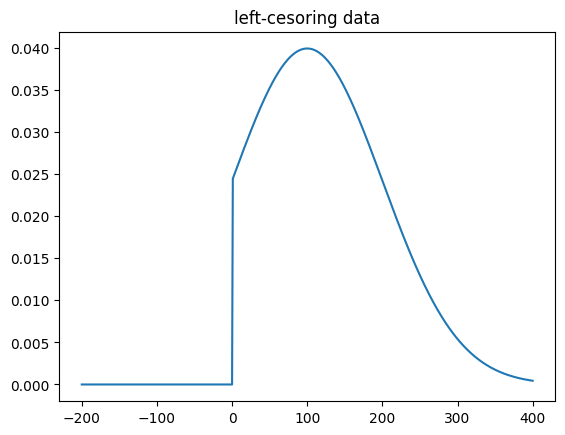

In [2]:
# 被説明変数が左打ち切りのグラフを実装
import numpy as np
import matplotlib.pyplot as plt

sigma, mu = 100, 100
threshold = 0
normdist = lambda x: 1/np.sqrt(2*np.pi*sigma)*np.exp(-1*((x-mu)**2)/(2*(sigma**2))) if x > 0 else 0
x = list(range(-200, 401))
y = list(map(normdist, x))

plt.title("left-cesoring data")
plt.plot(x, y)
plt.show() # 0以下の値を左打ち切りの例

# タイプ$I$トービットモデル

$y_i$を実際の観測値、$y_i^*$を**潜在変数**とする。  
潜在変数$y_i^*$に打ち切りが伴うが、説明変数$x_i$は常に観測可能である。  
タイプ$I$トービットモデルにおいて、観測値$y_i$と潜在変数$y_i^*$の関係は以下の3つのケースに分けられる。  
左打ち切りが伴う場合：
$y_i = \begin{cases}
y_i^* & (y_i^* > L)\\
L & (y_i^* \leq L) \\
\end{cases}$

右打ち切りが伴う場合：
$y_i = \begin{cases}
y_i^* & (y_i^* < U)\\
U & (y_i^* \geq U) \\
\end{cases}$

両側打ち切りが伴う場合：
$y_i = \begin{cases}
y_i^* & (L < y_i^* < U)\\
L & (y_i^* \leq L) \\
U & (y_i^* \geq U) \\
\end{cases}$

ただし$L,U$は定数である。

In [6]:
# MROZデータセットで実践
# https://github.com/spring-haru/wooldridge/blob/master/raw_data/data_csv/mroz.csv
import wooldridge
from py4etrics.tobit import Tobit

mroz_df = wooldridge.data('mroz')
mroz_df.head()

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
0,1,1610,1,0,32,12,3.3540,2.65,2708,34,...,16310.0,0.7215,12,7,5.0,0,14,10.910060,1.210154,196
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,...,21800.0,0.6615,7,7,11.0,1,5,19.499981,0.328512,25
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,...,21040.0,0.6915,12,7,5.0,0,15,12.039910,1.514138,225
3,1,456,0,3,34,12,1.0965,3.25,1920,53,...,7300.0,0.7815,7,7,5.0,0,6,6.799996,0.092123,36
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,...,27300.0,0.6215,12,14,9.5,1,7,20.100058,1.524272,49


In [7]:
mroz_df.describe()

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,428.000000,753.000000,753.000000,753.000000,...,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.00000,753.000000,428.000000,753.000000
mean,0.568393,740.576361,0.237716,1.353254,42.537849,12.286853,4.177682,1.849734,2267.270916,45.120850,...,23080.594954,0.678863,9.250996,8.808765,8.623506,0.642762,10.63081,20.128964,1.190173,178.038513
std,0.495630,871.314216,0.523959,1.319874,8.072574,2.280246,3.310282,2.419887,595.566649,8.058793,...,12190.202026,0.083496,3.367468,3.572290,3.114934,0.479504,8.06913,11.634797,0.723198,249.630849
min,0.000000,0.000000,0.000000,0.000000,30.000000,5.000000,0.128200,0.000000,175.000000,30.000000,...,1500.000000,0.441500,0.000000,0.000000,3.000000,0.000000,0.00000,-0.029057,-2.054164,0.000000
25%,0.000000,0.000000,0.000000,0.000000,36.000000,12.000000,2.262600,0.000000,1928.000000,38.000000,...,15428.000000,0.621500,7.000000,7.000000,7.500000,0.000000,4.00000,13.025040,0.816509,16.000000
50%,1.000000,288.000000,0.000000,1.000000,43.000000,12.000000,3.481900,0.000000,2164.000000,46.000000,...,20880.000000,0.691500,10.000000,7.000000,7.500000,1.000000,9.00000,17.700001,1.247574,81.000000
75%,1.000000,1516.000000,0.000000,2.000000,49.000000,13.000000,4.970750,3.580000,2553.000000,52.000000,...,28200.000000,0.721500,12.000000,12.000000,11.000000,1.000000,15.00000,24.466000,1.603571,225.000000
max,1.000000,4950.000000,3.000000,8.000000,60.000000,17.000000,25.000000,9.980000,5010.000000,60.000000,...,96000.000000,0.941500,17.000000,17.000000,14.000000,1.000000,45.00000,96.000000,3.218876,2025.000000


In [8]:
# トービットモデルを構築(左打ち切り)
mroz_df
left = 0 # 下限の値
censor = mroz_df["hours"].apply(lambda x: -1 if x==left else 0)
formula = 'hours ~ 1 + nwifeinc + educ + exper + expersq + age + kidslt6 + kidsge6'
result_tobit = Tobit.from_formula(formula, cens=censor, left=0, data=mroz_df).fit()
print(result_tobit.summary())

Optimization terminated successfully.
         Current function value: 5.071839
         Iterations: 2480
         Function evaluations: 3603
                              Tobit Regression Results                             
Dep. Variable:                       hours   Pseudo R-squ:                    0.034
Method:                 Maximum Likelihood   Log-Likelihood:                -3819.1
No. Observations:                      753   LL-Null:                       -3954.9
No. Uncensored Obs:                    428   LL-Ratio:                        271.6
No. Left-censored Obs:                 325   LLR p-value:                     0.000
No. Right-censored Obs:                  0   AIC:                            7654.2
Df Residuals:                          745   BIC:                            7691.2
Df Model:                                7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

# 尤度関数

次のタイプ$I$トービットモデルを考える。
$$
y_i^* = x_i^T \beta + \epsilon_i, \quad i=1,2,...,n
$$
ただし、$\beta$はパラメータからなるベクトルで、$\epsilon_i$は互いに独立に正規分布$N(0,\sigma^2)$に従うとする。    
この場合の左打ち切りの場合の尤度関数を求めてみる。次のように定義関数を定める。
$$
I(y_i) = \begin{cases}
0 & (y_i^* \leq L)\\
1 & (y_i^* > L) \\
\end{cases}
$$
次に$\varphi(.)$, $\phi(.)$をそれぞれ標準正規関数の確率密度関数、累積分布関数とする。  
打ち切られる確率$P(y_i^* \leq L)$を考慮すると、$\beta, \sigma$に関する尤度関数は次のようになる。
$$
L(\beta, \sigma) = \prod_{i:y_i>L} \frac{1}{\sigma} \varphi \big(\frac{y_i - x_i^T \beta}{\sigma}\big) 
\prod_{i:y_i \leq L} \phi \big(\frac{L - x_i^T \beta}{\sigma}\big)
$$

# 生存時間解析

ある時点から、興味のあるイベント(病気の転移、完治、死亡)が観察されるまでの時間$T( \geq 0)$を**生存時間**という。  
生存時間解析の目的は、生存時間と関連情報(共変量)を用いて、生存率の推定や比較、さらに生存率と共変量の解明をすることである。  
生存時間解析の主要な目的は、**生存関数**
$$
S(t) = P(T>t) = \int_{t}^{\infty} f(x|\theta)dx
$$
の推定である。  
ただし、$f(x|\theta)$は$T$の確率密度関数で、$\theta$は未知のパラメータである。  
生存関数$S(t)$はイベントが発生するまでの時間が$t$を超える確率を表している。  
生存時間解析のモデル構築は生存関数モデルの構築であるが、そのためには**ハザード関数**からアプローチするのが一般的である。

# ハザード関数の例

例1  
生存時間$T$が指数分布に従い、確率密度関数を$f(t)=\lambda e^{- \lambda t}$とする。  
この時の生存関数は$S(t)=e^{- \lambda t}$で、ハザード関数は$h(t)= \lambda$となる。  
定常なハザードは健康状態が安定な人に対するモデル  

例2  
生存時間Tがワイブル分布に従い、確率密度関数を$f(t)=\lambda p(\lambda t)^{p-1} e^{-(\lambda t)^p}$とする。  
ワイブル分布は指数分布を一般化したモデルである。  
この時のハザード関数は、$h(t)= \lambda p(\lambda t)^{p-1}$となる。$p=1$のとき、$h(t)$は定数$p>1$のとき$h(t)$は単調増加、$p<1$のとき$h(t)$は単調減少である。  
たとえば、ある病気に対して、まったく治療を受けていない患者の死亡するハザードは時間とともに増加し、また手術などを受けた患者に対してハザードが単調減少すると考えられる。  
このときの生存関数は $S(t) = e^{-(\lambda t)^p}$となる。

# 比例ハザードモデル

たとえば、白血病患者の死亡をイベントとした場合、治療効果のほか、**予後因子**である患者の白血球数などの共変量$x$を考慮する必要がある。  
一般化線形モデルにおいては、連結関数$g(.)$を用いて、$E(T|x)=g(x^T \beta)$の仮定をおき、反復重み付き最小二乗法を用い$\beta$の推定を行う。  
生存時間解析において、$E(T|x)$の代わりに、ハザード関数を用いて、
$$
h(t;x) = \exp(\alpha + x^T \beta) = h_0 e^{x^T \beta}, \quad (h_0=e^{\alpha}>0)
$$
を仮定する。  
上記モデルにおけるハザードは時間に依存せず、生存時間$T$の分布は指数分布に限られる。  
確率密度関数$f(t)=\lambda \exp(- \lambda t)$をもつ指数分布のハザードは$\lambda$なので、$\lambda = h_0 e{x^T \beta}$として、最尤法で$\alpha、\beta$を推定できる。  
指数分布を仮定した回帰モデルにおける$h_0$を$h_0(t)$で置き換えて得られたのが、**Cox比例ハザードモデル**である。
$$
h(t;x) = h_0(t) e^{x^T \beta}, \quad (h_0(t)>0)
$$
$h_0(t)=h(t;x=0)$なので、$h_0(t)$は**基準ハザード**とよばれる。  
$h_0(t)$は$t$の関数であるが、その形を全く指定しないため、比例ハザードモデルはセミ・パラメトリック・モデルの一種である。  
比例ハザードモデルが広く使われている理由は、基準ハザード関数$h_0(t)$における制約をおいていないことである。  
したがって、生存時間$T$の分布がどんな分布であっても、比例ハザードモデルに基づく解析は頑健的な結果を保証する。

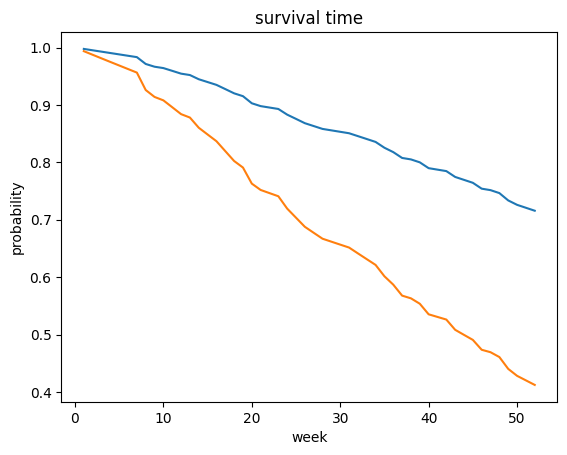

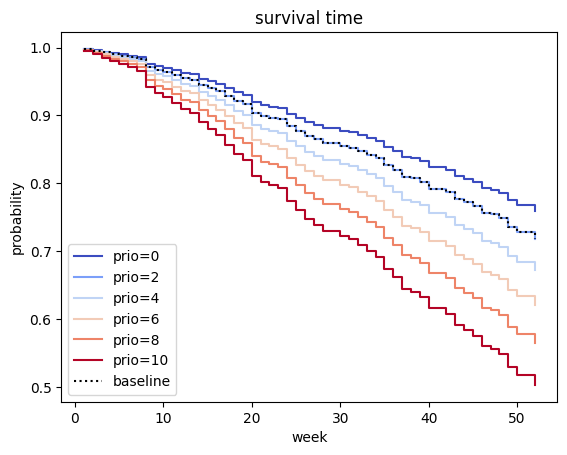

In [10]:
# Cox比例ハザードモデルを実装
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

# メリーランド州受刑者の追跡調査データを取得
rossi = load_rossi()

# Cox比例ハザードモデル生成
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')

# 推測を実行
result = cph.predict_survival_function(rossi)

# 結果をプロット
sample0 = result.iloc[:, 0] # 過去の受刑回数3回の生存確率
sample1 = result.iloc[:, 1] # 過去の受刑回数8回の生存確率
plt.title("survival time")
plt.plot(sample0.index, sample0)
plt.plot(sample1.index, sample1)
plt.ylabel("probability")
plt.xlabel("week")
plt.show() # 2倍程度の開きがあることを確認

# 共変量の可視化
cph.fit(rossi, duration_col='week', event_col='arrest')
cph.plot_partial_effects_on_outcome(
    covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm'
)
plt.title("survival time")
plt.ylabel("probability")
plt.xlabel("week")
plt.show()

過去の受刑回数の値が大きいほど生存確率は下にくることが確認できる。

# カプラン・マイヤー推定量

パラメトリック・モデルの適用が難しい場合、生存関数の推定量を次のように構成できる。  
大きさ$n$の無作為標本$t_1,...,t_n$に対して、まず打ち切りがない場合を考える。  
$S(t) = 1-F(T)$により、経験分布$F_n(t)$を用いて、
$$
\hat{S}(t) = 1-F_n(t) = \frac{1}{n} \sum_{i=1}^{n}I(t_i>t)
$$で推定できる。ただし、$I(.)$は定義関数である。  
推定量$\hat{S}(t)$は**カプラン・マイヤー推定量**の特殊な場合である。  
タイがなければ、$\hat{S}(t)$は死亡時刻ごとに$1/n$ずつ減少する階段関数である。  
次に右打ち切りが伴う場合を考える。  
たとえば、ある病気の手術を行った後に死亡するまでの生存時間を分析する場合、患者の店員などの理由で、それらの患者については生存時間が打ち切られて観測できないことがある。  
$n$人の患者を観察し始めたとして、時刻$t>0$までに時刻$0<t_1<t_2<..<t_k<t$で死亡が確認されたとする。  
時刻$t_i$での死亡数を$d_i$とする。また、「時刻$t_i$より前までは生存していたことがわかっている人数」を$n_i$とする。  
つまり、$n_i$は最初の$n$人から時刻$t_i$より前に死亡した人数および右打ち切りされた人数を引いた人数を表す。  
このときカプラン・マイヤー推定量は、
$$
\hat{S}(t) = \begin{cases} 
1 & (t < t_1) \\
\prod_{i:t_i \leq t} \frac{n_i-d_i}{n_i} & (t \geq t_1) \\
\end{cases}
$$
で与えられる。  
時刻$t_j$におけるカプラン・マイヤー推定量は、直前の時刻$t_j-1$における推定量と、$t_j$まで生きていた条件のもとでの$t_j$を乗り越える条件付き確率の推定量との積で表すことができる。  
すなわち、
$$
\hat{S}(t_j) = \prod_{i=1}^{j} \hat{P}[T>t_i|T\geq t_i]
$$
と条件付き生存確率の積で表現できることがわかる。

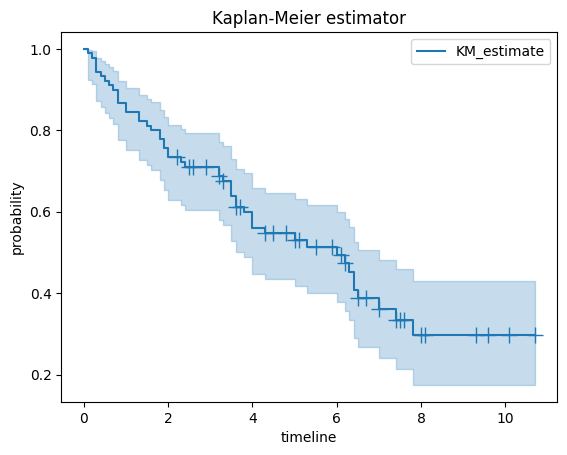

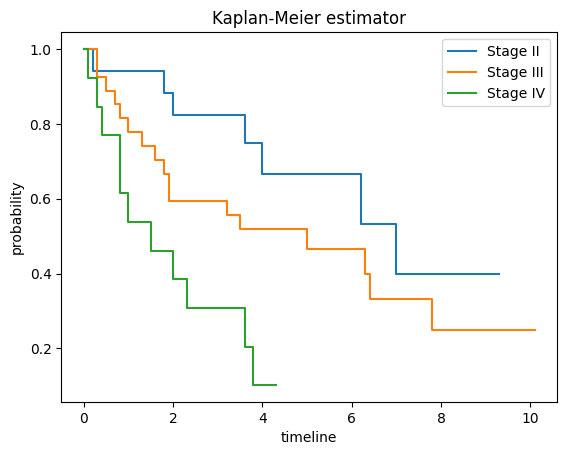

In [11]:
# カプラン・マイヤー推定量を実装
from lifelines.datasets import load_larynx
from lifelines import KaplanMeierFitter

# 喉頭癌のステージ別・年齢別の生存期間データを取得
larynx_data = load_larynx()

# カプラン・マイヤーモデルを生成
kmf = KaplanMeierFitter()
kmf.fit(durations=larynx_data.time, event_observed=larynx_data.death)

# 生存曲線(カプラン・マイヤー曲線)を描画
kmf.plot(show_censors=True)
plt.title("Kaplan-Meier estimator")
plt.ylabel("probability")
plt.show()

# ステージ毎の生存曲線を描画
larynx_data_stage2 = larynx_data.query('Stage_II == 1')
larynx_data_stage3 = larynx_data.query('Stage_III == 1')
larynx_data_stage4 = larynx_data.query('Stage_IV == 1')

kmf2 = KaplanMeierFitter()
kmf2.fit(durations=larynx_data_stage2.time, event_observed=larynx_data_stage2.death, label='Stage II')
kmf2.plot(ci_show=False)
kmf3 = KaplanMeierFitter()
kmf3.fit(durations=larynx_data_stage3.time, event_observed=larynx_data_stage3.death, label='Stage III')
kmf3.plot(ci_show=False)
kmf4 = KaplanMeierFitter()
kmf4.fit(durations=larynx_data_stage4.time, event_observed=larynx_data_stage4.death, label='Stage IV')
kmf4.plot(ci_show=False)

plt.title("Kaplan-Meier estimator")
plt.ylabel("probability")
plt.show()

ステージが高いほど生存曲線が低いことが確認できる。

# ニューラルネットワークモデル

非線形回帰分析の一つの手法として、最近人工知能分野で多用される**ニューラルネットワークモデル**がある。  
※記載は省略する。